<a href="https://colab.research.google.com/github/DanielCalderon97/Proyecto_Final_Text_Minning_Image/blob/main/ProyectoFinal_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final Problema 2
### Daniel Calderón - 24000152

#### Parte 1: Dataset

In [42]:
# Parametros que nos servirán durante todo el desarrollo

SEED = 2025
IMG_SIZE = (180, 180)       # (alto, ancho)
COLOR_MODE = "rgb"          # use el 'rgb'
BATCH_SIZE = 32
VAL_SPLIT = 0.20
TEST_SPLIT = 0.20
EPOCHS = 10
USE_AUGMENTATION = True
SAVE_TO_DRIVE = False

# Nombre de la carpeta principal dentro del ZIP
DATASET_DIR_NAME = "Fruits_Vegetables_Dataset(12000)"

print("Parámetros OK")

Parámetros OK


In [43]:
# Montamos Google Drive
# Ruta al archivo en tu Google Drive

from google.colab import drive
drive.mount('/content/drive')

import os, zipfile, shutil

zip_path = "/content/drive/MyDrive/Colab Notebooks/ProyectoFinal/archive.zip"
assert os.path.exists(zip_path), f"No se encontró: {zip_path}"
print("ZIP:", zip_path)

# Extraemos contenido

EXTRACT_DIR = "/content/dataset_full"
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(EXTRACT_DIR)
print("Descomprimido en:", EXTRACT_DIR)

# Declaramos rutas
DATA_ROOT = f"{EXTRACT_DIR}/{DATASET_DIR_NAME}"
FRUITS_DIR = f"{DATA_ROOT}/Fruits"
VEGGIES_DIR = f"{DATA_ROOT}/Vegetables"

for p in [DATA_ROOT, FRUITS_DIR, VEGGIES_DIR]:
    assert os.path.exists(p), f"Ruta no encontrada: {p}"
print("Fruits dir:", FRUITS_DIR)
print("Vegetables dir:", VEGGIES_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP: /content/drive/MyDrive/Colab Notebooks/ProyectoFinal/archive.zip
Descomprimido en: /content/dataset_full
Fruits dir: /content/dataset_full/Fruits_Vegetables_Dataset(12000)/Fruits
Vegetables dir: /content/dataset_full/Fruits_Vegetables_Dataset(12000)/Vegetables


In [44]:
# Mapa: [subcarpetas_de_origen]
# Para el trabajo escogí en Frutas: Manzana, Banano y Naranjas || y en Verduras: tomate, papa y zanahoria
# Unimos ambas carpetas de los alimentos: las imagenes "frescas" y las "podridas"

CLASS_MAP = {
    "Apple":  ["FreshApple",  "RottenApple"],
    "Banana": ["FreshBanana", "RottenBanana"],
    "Orange": ["FreshOrange", "RottenOrange"],
    "Carrot": ["FreshCarrot", "RottenCarrot"],
    "Potato": ["FreshPotato", "RottenPotato"],
    "Tomato": ["FreshTomato", "RottenTomato"],
}

print("Clases seleccionadas:", list(CLASS_MAP.keys()))

Clases seleccionadas: ['Apple', 'Banana', 'Orange', 'Carrot', 'Potato', 'Tomato']


In [45]:
# Construimos conjunto **RAW** con clases unificadas

import os, shutil, glob

RAW_DIR = "/content/data_raw"
if os.path.exists(RAW_DIR):
    shutil.rmtree(RAW_DIR)
os.makedirs(RAW_DIR, exist_ok=True)

def copy_merge_class(dst_class, subfolders):
    dst_dir = os.path.join(RAW_DIR, dst_class)
    os.makedirs(dst_dir, exist_ok=True)
    for sub in subfolders:
        # Determinar si la subcarpeta viene de Frutas o Vegetales
        src = None
        if os.path.exists(os.path.join(FRUITS_DIR, sub)):
            src = os.path.join(FRUITS_DIR, sub)
        elif os.path.exists(os.path.join(VEGGIES_DIR, sub)):
            src = os.path.join(VEGGIES_DIR, sub)
        else:
            raise FileNotFoundError(f"No existe subcarpeta: {sub} en Fruits/Vegetables")
        # Copiar imágenes
        for ext in ["*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp"]:
            for img in glob.glob(os.path.join(src, ext)):
                shutil.copy2(img, os.path.join(dst_dir, os.path.basename(img)))

for cls, subs in CLASS_MAP.items():
    copy_merge_class(cls, subs)

# Verificación rápida de la cantidad de imagenes por carpeta
for cls in sorted(os.listdir(RAW_DIR)):
    n = len(os.listdir(os.path.join(RAW_DIR, cls)))
    print(f"{cls:>8}: {n} imágenes")

   Apple: 1199 imágenes
  Banana: 1195 imágenes
  Carrot: 1199 imágenes
  Orange: 1200 imágenes
  Potato: 1198 imágenes
  Tomato: 1199 imágenes


In [46]:
# Split train/val/test (estratificado)

import random, math

BASE_DIR = "/content/data_split"
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
os.makedirs(BASE_DIR, exist_ok=True)
for sp in ["train","val","test"]:
    os.makedirs(os.path.join(BASE_DIR, sp), exist_ok=True)

train_ratio = 1.0 - (VAL_SPLIT + TEST_SPLIT)
val_ratio   = VAL_SPLIT
test_ratio  = TEST_SPLIT
print(f"Ratios -> train={train_ratio:.2f}, val={val_ratio:.2f}, test={test_ratio:.2f}")

def stratified_split(class_dir, seed=SEED):
    imgs = []
    for ext in ["*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp"]:
        imgs += glob.glob(os.path.join(class_dir, ext))
    imgs = sorted(imgs)
    rnd = random.Random(seed); rnd.shuffle(imgs)
    n = len(imgs)
    n_train = int(n*train_ratio); n_val = int(n*val_ratio)
    return imgs[:n_train], imgs[n_train:n_train+n_val], imgs[n_train+n_val:]

def copy_files(files, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for src in files:
        shutil.copy2(src, os.path.join(dst_dir, os.path.basename(src)))

counts = {}
for cls in sorted(os.listdir(RAW_DIR)):
    src_cls_dir = os.path.join(RAW_DIR, cls)
    tr, va, te = stratified_split(src_cls_dir, seed=SEED)
    counts[cls] = dict(train=len(tr), val=len(va), test=len(te), total=len(os.listdir(src_cls_dir)))
    copy_files(tr, os.path.join(BASE_DIR, "train", cls))
    copy_files(va, os.path.join(BASE_DIR, "val", cls))
    copy_files(te, os.path.join(BASE_DIR, "test", cls))

print("Conteos por clase:")
for k,v in counts.items():
    print(f"{k:>8} -> train={v['train']}, val={v['val']}, test={v['test']} (total={v['total']})")

Ratios -> train=0.60, val=0.20, test=0.20
Conteos por clase:
   Apple -> train=719, val=239, test=241 (total=1199)
  Banana -> train=717, val=239, test=239 (total=1195)
  Carrot -> train=719, val=239, test=241 (total=1199)
  Orange -> train=720, val=240, test=240 (total=1200)
  Potato -> train=718, val=239, test=241 (total=1198)
  Tomato -> train=719, val=239, test=241 (total=1199)


In [47]:
# Generators + Data Augmentation

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if USE_AUGMENTATION:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.15, height_shift_range=0.15,
        zoom_range=0.2, shear_range=0.15,
        horizontal_flip=True,
        brightness_range=(0.8,1.2),
        fill_mode="nearest"
    )
else:
    train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train"),
    target_size=IMG_SIZE, color_mode=COLOR_MODE,
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=True, seed=SEED
)
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "val"),
    target_size=IMG_SIZE, color_mode=COLOR_MODE,
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "test"),
    target_size=IMG_SIZE, color_mode=COLOR_MODE,
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
print("Clases:", class_indices)

Found 4301 images belonging to 6 classes.
Found 1433 images belonging to 6 classes.
Found 1442 images belonging to 6 classes.
Clases: {'Apple': 0, 'Banana': 1, 'Carrot': 2, 'Orange': 3, 'Potato': 4, 'Tomato': 5}


In [48]:
# Modelo CNN
from tensorflow.keras import layers, models, callbacks, optimizers

channels = 3 if COLOR_MODE=="rgb" else 1
input_shape = (IMG_SIZE[0], IMG_SIZE[1], channels)

def build_cnn(input_shape, num_classes):
    x_in = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,padding="same",activation="relu")(x_in)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,3,padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256,3,padding="same",activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(x_in, out, name="FruitsVeg_CNN_paths")

model = build_cnn(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "FruitsVeg_CNN_paths"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,006 (1.62 MB)

 Trainable params: 423,046 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [49]:
#Entrenamiento

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_gen, validation_data=val_gen,
    epochs=EPOCHS, callbacks=[es, rlr], verbose=1
)
print("Entrenamiento finalizado.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 69s 447ms/step - accuracy: 0.3765 - loss: 1.7014 - val_accuracy: 0.1668 - val_loss: 3.4664 - learning_rate: 0.0010
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 55s 406ms/step - accuracy: 0.6172 - loss: 1.0609 - val_accuracy: 0.1689 - val_loss: 3.2609 - learning_rate: 0.0010
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 411ms/step - accuracy: 0.6872 - loss: 0.9080 - val_accuracy: 0.3098 - val_loss: 2.5749 - learning_rate: 0.0010
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 54s 402ms/step - accuracy: 0.7398 - loss: 0.7454 - val_accuracy: 0.6469 - val_loss: 1.0001 - learning_rate: 0.0010
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 54s 399ms/step - accuracy: 0.7526 - loss: 0.7045 - val_accuracy: 0.7544 - val_loss: 0.7098 - learning_rate: 0.0010
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 53s 396ms/step - accuracy: 0.7720 - loss: 0.6260 - val_accuracy: 0.6434 - val_loss: 1.1233 - learning_rate: 0.0010
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 55s 404ms/step - accuracy: 0.7

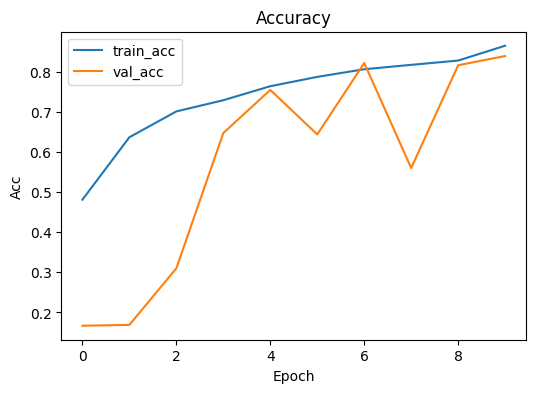

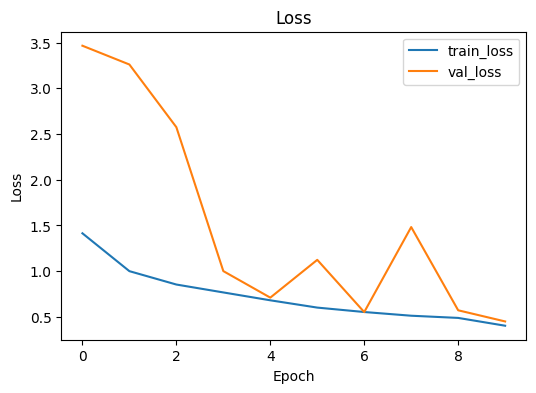

Test accuracy: 0.8474 | loss: 0.4412

Classification Report:
              precision    recall  f1-score   support

       Apple       0.80      0.83      0.82       240
      Banana       0.91      0.79      0.85       239
      Carrot       0.93      0.85      0.89       241
      Orange       0.89      0.87      0.88       240
      Potato       0.70      0.94      0.80       241
      Tomato       0.92      0.80      0.86       241

    accuracy                           0.85      1442
   macro avg       0.86      0.85      0.85      1442
weighted avg       0.86      0.85      0.85      1442



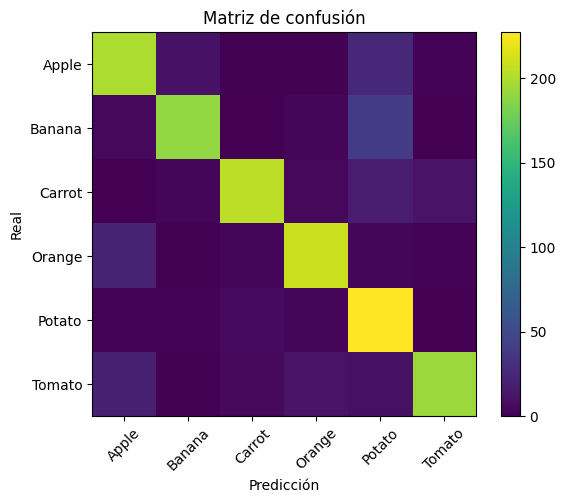

In [50]:
# Curvas, evaluación y matriz de confusión
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Curvas
hist = history.history
plt.figure(figsize=(6,4)); plt.plot(hist["accuracy"], label="train_acc"); plt.plot(hist["val_accuracy"], label="val_acc")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Test
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | loss: {test_loss:.4f}")

probs = model.predict(test_gen, verbose=0)
y_pred = np.argmax(probs, axis=1)
y_true = test_gen.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(idx_to_class))]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation="nearest"); plt.title("Matriz de confusión"); plt.colorbar()
ticks = np.arange(len(idx_to_class))
plt.xticks(ticks, [idx_to_class[i] for i in ticks], rotation=45)
plt.yticks(ticks, [idx_to_class[i] for i in ticks])
plt.xlabel("Predicción"); plt.ylabel("Real"); plt.tight_layout(); plt.show()


#### Parte2: Diseño y Entrenamiento de la Red Neuronal Convolucional

In [51]:
# Parámetros + BASE_DIR

SEED = 2025
IMG_SIZE = (180, 180)
COLOR_MODE = "rgb"
BATCH_SIZE = 32
EPOCHS = 10
AUGMENT = True

from google.colab import drive
drive.mount('/content/drive')

import os
try:
    BASE_DIR = SPLIT_DIR  # viene de la Parte 1
except NameError:
    MANUAL_BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/ProyectoFinal/data_split"  # <- ajusta aquí si tu split quedó en otra carpeta
    BASE_DIR = MANUAL_BASE_DIR

# Validación rápida
for sub in ["train", "val", "test"]:
    assert os.path.exists(os.path.join(BASE_DIR, sub)), f"Falta {sub} en {BASE_DIR}. Vuelve a crear el split en la Parte 1."
print("Usaremos BASE_DIR:", BASE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usaremos BASE_DIR: /content/drive/MyDrive/Colab Notebooks/ProyectoFinal/data_split


In [52]:
# Generadores
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if AUGMENT:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        brightness_range=(0.8, 1.2),
        fill_mode="nearest",
    )
else:
    train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(BASE_DIR, "train"),
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)
val_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(BASE_DIR, "val"),
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(BASE_DIR, "test"),
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
print("Clases:", class_indices)


Found 5028 images belonging to 6 classes.
Found 1075 images belonging to 6 classes.
Found 1083 images belonging to 6 classes.
Clases: {'Apple': 0, 'Banana': 1, 'Carrot': 2, 'Orange': 3, 'Potato': 4, 'Tomato': 5}


In [53]:
# Callbacks + helpers
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

def common_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ]

def plot_curves(history, title=""):
    h = history.history
    plt.figure(figsize=(6,4)); plt.plot(h["accuracy"]); plt.plot(h["val_accuracy"]);
    plt.title(f"{title} Accuracy"); plt.legend(["train","val"]); plt.xlabel("epoch"); plt.show()
    plt.figure(figsize=(6,4)); plt.plot(h["loss"]); plt.plot(h["val_loss"]);
    plt.title(f"{title} Loss"); plt.legend(["train","val"]); plt.xlabel("epoch"); plt.show()

def evaluate_model(model, test_gen, idx_to_class):
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    probs = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    y_true = test_gen.classes
    rep_df = pd.DataFrame(classification_report(
        y_true, y_pred, target_names=[idx_to_class[i] for i in range(len(idx_to_class))], output_dict=True)).T
    cm = confusion_matrix(y_true, y_pred)
    return test_loss, test_acc, rep_df, cm

def plot_confusion(cm, idx_to_class, title="Matriz de confusión"):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(idx_to_class))
    plt.xticks(ticks, [idx_to_class[i] for i in ticks], rotation=45)
    plt.yticks(ticks, [idx_to_class[i] for i in ticks])
    plt.xlabel("Predicción"); plt.ylabel("Real"); plt.tight_layout(); plt.show()


Model: "SimpleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,006 (30.61 MB)

 Trainable params: 8,024,006 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 77/158 ━━━━━━━━━━━━━━━━━━━━ 38s 480ms/step - accuracy: 0.2389 - loss: 1.7543

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 87s 529ms/step - accuracy: 0.3084 - loss: 1.6282 - val_accuracy: 0.6009 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 79s 499ms/step - accuracy: 0.5994 - loss: 1.0690 - val_accuracy: 0.7219 - val_loss: 0.8170 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 79s 499ms/step - accuracy: 0.6785 - loss: 0.8917 - val_accuracy: 0.7712 - val_loss: 0.6748 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.7451 - loss: 0.6962 - val_accuracy: 0.8149 - val_loss: 0.5586 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 79s 502ms/step - accuracy: 0.7703 - loss: 0.6484 - val_accuracy: 0.8512 - val_loss: 0.4684 - learning_rate: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 79s 500ms/step - accuracy: 0.8097 - loss: 0.5234 - val_accuracy: 0.8707 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 79s 497ms/step - accuracy: 0.8380 - loss:

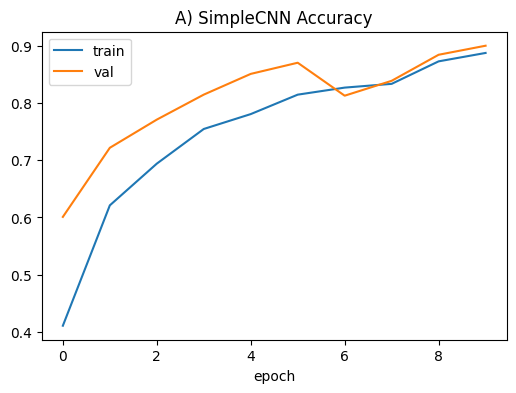

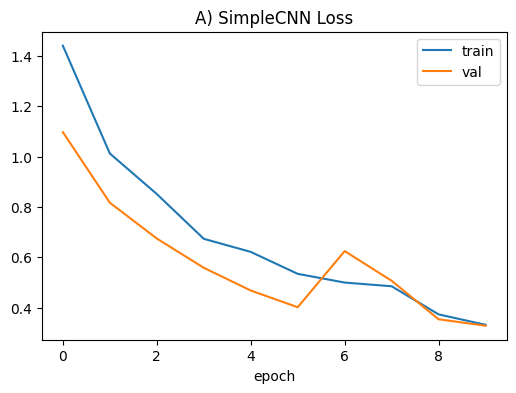

A) SimpleCNN — Test Acc: 0.9003 | Loss: 0.3708


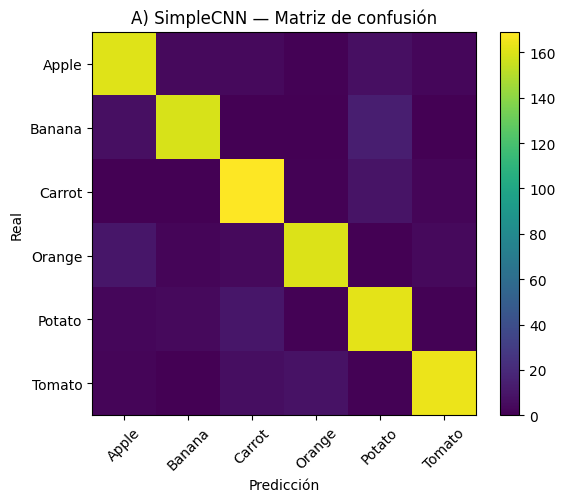

,precision,recall,f1-score,support
Apple,0.879781,0.894444,0.887052,180.0
Banana,0.940828,0.883333,0.911175,180.0
Carrot,0.875648,0.933702,0.903743,181.0
Orange,0.935673,0.888889,0.911681,180.0
Potato,0.839378,0.895028,0.866310,181.0


In [54]:
# Modelo A (SimpleCNN)
from tensorflow.keras import layers, models, optimizers

channels = 3 if COLOR_MODE == "rgb" else 1
input_shape = (IMG_SIZE[0], IMG_SIZE[1], channels)

def build_simple_cnn(input_shape, num_classes):
    x_in = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x_in)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(x_in, out, name="SimpleCNN")

model_A = build_simple_cnn(input_shape, num_classes)
model_A.compile(optimizer=optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model_A.summary()

hist_A = model_A.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=common_callbacks(), verbose=1)
plot_curves(hist_A, "A) SimpleCNN")

loss_A, acc_A, rep_A, cm_A = evaluate_model(model_A, test_gen, idx_to_class)
print(f"A) SimpleCNN — Test Acc: {acc_A:.4f} | Loss: {loss_A:.4f}")
plot_confusion(cm_A, idx_to_class, "A) SimpleCNN — Matriz de confusión")
rep_A.head()


Model: "DeepCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,425,638 (9.25 MB)

 Trainable params: 2,422,694 (9.24 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/10
 97/158 ━━━━━━━━━━━━━━━━━━━━ 36s 603ms/step - accuracy: 0.3548 - loss: 1.9321

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 117s 621ms/step - accuracy: 0.3971 - loss: 1.7994 - val_accuracy: 0.1665 - val_loss: 4.5400 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 83s 524ms/step - accuracy: 0.6298 - loss: 1.1995 - val_accuracy: 0.3358 - val_loss: 2.1455 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 88s 557ms/step - accuracy: 0.6817 - loss: 1.0202 - val_accuracy: 0.5237 - val_loss: 1.5863 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 84s 531ms/step - accuracy: 0.7136 - loss: 0.9578 - val_accuracy: 0.7033 - val_loss: 1.0509 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 84s 534ms/step - accuracy: 0.7530 - loss: 0.8530 - val_accuracy: 0.7367 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 83s 526ms/step - accuracy: 0.7873 - loss: 0.7697 - val_accuracy: 0.7907 - val_loss: 0.8086 - learning_rate: 0.0010
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 84s 530ms/step - accuracy: 0.7987 - loss

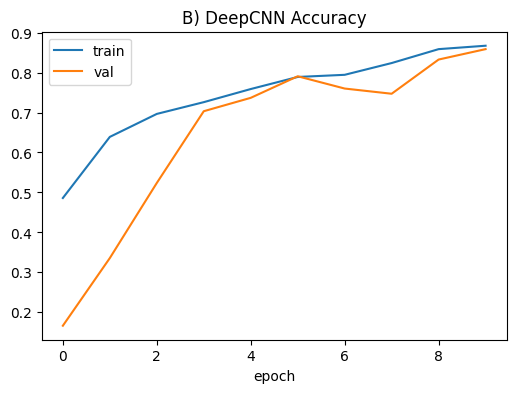

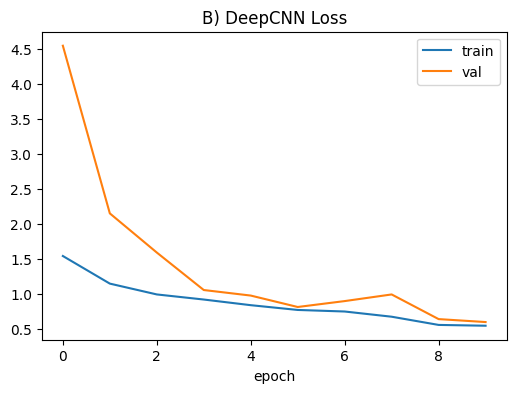

 B) DeepCNN — Test Acc: 0.8643 | Loss: 0.5834


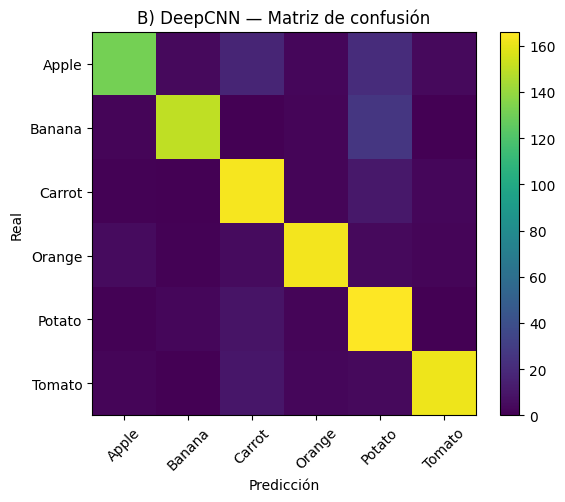

,precision,recall,f1-score,support
Apple,0.922535,0.727778,0.813665,180.0
Banana,0.949367,0.833333,0.887574,180.0
Carrot,0.800000,0.906077,0.849741,181.0
Orange,0.931429,0.905556,0.918310,180.0
Potato,0.715517,0.917127,0.803874,181.0


In [55]:
# Modelo B (DeepCNN)
from tensorflow.keras import regularizers

def block_bn(x, filters, l2=1e-4):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    return x

def build_deep_cnn(input_shape, num_classes, l2=1e-4):
    x_in = layers.Input(shape=input_shape)
    x = block_bn(x_in, 32, l2)
    x = block_bn(x, 64, l2)
    x = block_bn(x, 128, l2)
    x = block_bn(x, 256, l2)
    x = block_bn(x, 256, l2)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(x_in, out, name="DeepCNN")

model_B = build_deep_cnn(input_shape, num_classes)
model_B.compile(optimizer=optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model_B.summary()

hist_B = model_B.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=common_callbacks(), verbose=1)
plot_curves(hist_B, "B) DeepCNN")

loss_B, acc_B, rep_B, cm_B = evaluate_model(model_B, test_gen, idx_to_class)
print(f" B) DeepCNN — Test Acc: {acc_B:.4f} | Loss: {loss_B:.4f}")
plot_confusion(cm_B, idx_to_class, "B) DeepCNN — Matriz de confusión")
rep_B.head()


Found 5028 images belonging to 6 classes.
Found 1075 images belonging to 6 classes.
Found 1083 images belonging to 6 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_head"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  7/158 ━━━━━━━━━━━━━━━━━━━━ 1:15 501ms/step - accuracy: 0.1523 - loss: 2.3292

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 788ms/step - accuracy: 0.6472 - loss: 0.9780 - val_accuracy: 0.9340 - val_loss: 0.2053 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 108s 653ms/step - accuracy: 0.9292 - loss: 0.2177 - val_accuracy: 0.9526 - val_loss: 0.1556 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 99s 627ms/step - accuracy: 0.9480 - loss: 0.1629 - val_accuracy: 0.9544 - val_loss: 0.1488 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 99s 626ms/step - accuracy: 0.9545 - loss: 0.1375 - val_accuracy: 0.9591 - val_loss: 0.1212 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 99s 629ms/step - accuracy: 0.9643 - loss: 0.1150 - val_accuracy: 0.9619 - val_loss: 0.1181 - learning_rate: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 101s 641ms/step - accuracy: 0.9670 - loss: 0.0982 - val_accuracy: 0.9581 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 106s 669ms/step - accuracy: 0.9685 - l

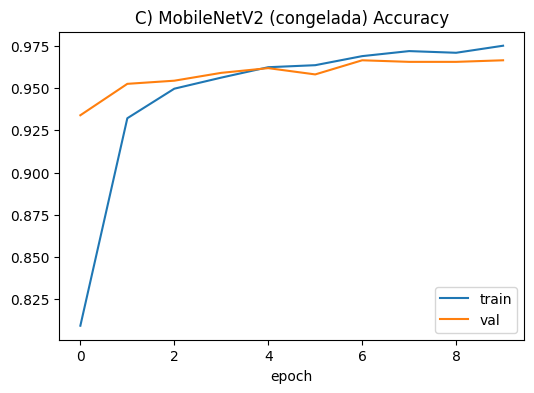

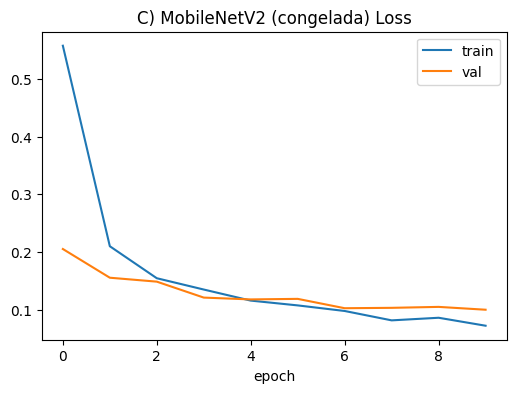

 C) MNV2-head — Test Acc: 0.9668 | Loss: 0.1107


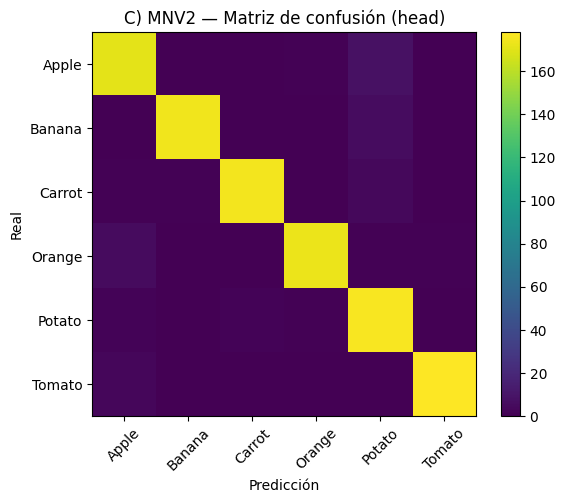

Epoch 1/5
 53/158 ━━━━━━━━━━━━━━━━━━━━ 1:20 770ms/step - accuracy: 0.8975 - loss: 0.2684

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


158/158 ━━━━━━━━━━━━━━━━━━━━ 143s 758ms/step - accuracy: 0.9247 - loss: 0.2066 - val_accuracy: 0.9637 - val_loss: 0.1293 - learning_rate: 1.0000e-04
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 116s 666ms/step - accuracy: 0.9774 - loss: 0.0605 - val_accuracy: 0.9247 - val_loss: 0.2700 - learning_rate: 1.0000e-04
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9817 - loss: 0.0558
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
158/158 ━━━━━━━━━━━━━━━━━━━━ 138s 639ms/step - accuracy: 0.9817 - loss: 0.0558 - val_accuracy: 0.9572 - val_loss: 0.1659 - learning_rate: 1.0000e-04
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 142s 636ms/step - accuracy: 0.9888 - loss: 0.0378 - val_accuracy: 0.9693 - val_loss: 0.1363 - learning_rate: 5.0000e-05


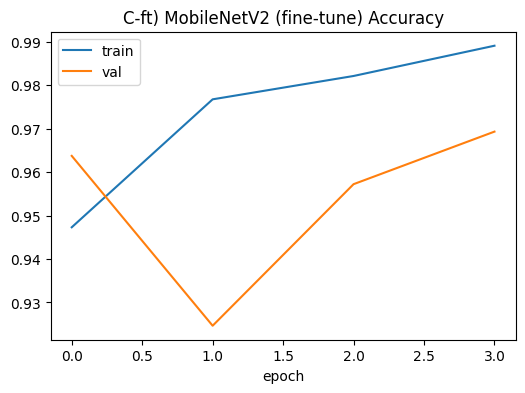

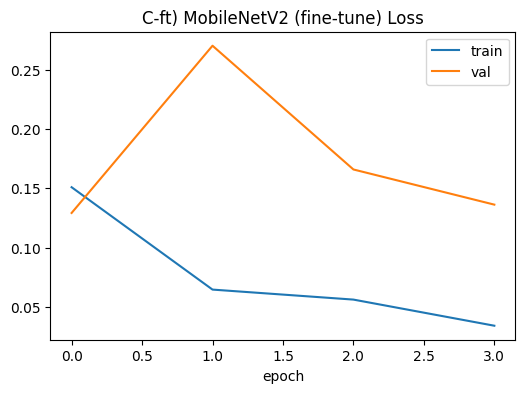

 C-ft) MNV2 — Test Acc: 0.9695 | Loss: 0.1310


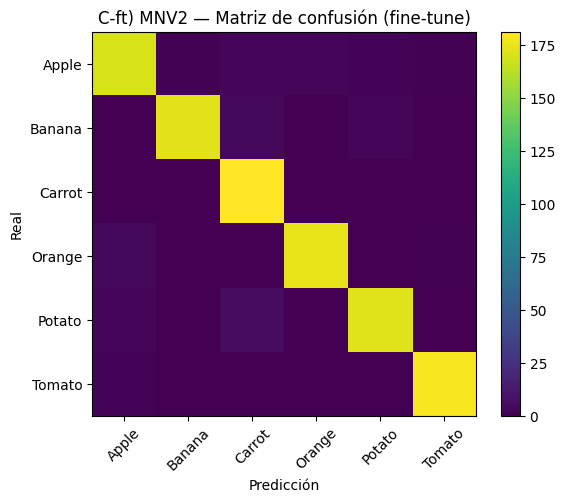

,precision,recall,f1-score,support
Apple,0.949721,0.944444,0.947075,180.0
Banana,0.994253,0.961111,0.977401,180.0
Carrot,0.932990,1.000000,0.965333,181.0
Orange,0.983146,0.972222,0.977654,180.0
Potato,0.971751,0.950276,0.960894,181.0


In [56]:
# Modelo C (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

# MobileNetV2 espera 224x224 RGB
IMG_TL = (224, 224)

train_tl = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    rotation_range=25, width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.2, shear_range=0.15, horizontal_flip=True,
    brightness_range=(0.8,1.2), fill_mode="nearest"
).flow_from_directory(
    os.path.join(BASE_DIR, "train"),
    target_size=IMG_TL, color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
val_tl = ImageDataGenerator(preprocessing_function=mobilenet_preprocess).flow_from_directory(
    os.path.join(BASE_DIR, "val"),
    target_size=IMG_TL, color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=False
)
test_tl = ImageDataGenerator(preprocessing_function=mobilenet_preprocess).flow_from_directory(
    os.path.join(BASE_DIR, "test"),
    target_size=IMG_TL, color_mode="rgb", class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=False
)

def build_mnv2_head(num_classes):
    base = MobileNetV2(input_shape=(IMG_TL[0], IMG_TL[1], 3), include_top=False, weights="imagenet")
    base.trainable = False  # 1) congelado
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(base.input, out, name="MobileNetV2_head")
    return model, base

model_C, base = build_mnv2_head(num_classes)
model_C.compile(optimizer=optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model_C.summary()

# Entrenamiento solo de la "cabeza"
hist_C = model_C.fit(train_tl, validation_data=val_tl, epochs=EPOCHS, callbacks=common_callbacks(), verbose=1)
plot_curves(hist_C, "C) MobileNetV2 (congelada)")

loss_C, acc_C, rep_C, cm_C = evaluate_model(model_C, test_tl, idx_to_class)
print(f" C) MNV2-head — Test Acc: {acc_C:.4f} | Loss: {loss_C:.4f}")
plot_confusion(cm_C, idx_to_class, "C) MNV2 — Matriz de confusión (head)")

# Fine-tuning (desbloquear parte superior del backbone)
UNFREEZE_FROM = 100
for i, layer in enumerate(base.layers):
    layer.trainable = (i >= UNFREEZE_FROM)

model_C.compile(optimizer=optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
hist_Cft = model_C.fit(train_tl, validation_data=val_tl, epochs=max(5, EPOCHS//2), callbacks=common_callbacks(), verbose=1)
plot_curves(hist_Cft, "C-ft) MobileNetV2 (fine-tune)")

loss_Cft, acc_Cft, rep_Cft, cm_Cft = evaluate_model(model_C, test_tl, idx_to_class)
print(f" C-ft) MNV2 — Test Acc: {acc_Cft:.4f} | Loss: {loss_Cft:.4f}")
plot_confusion(cm_Cft, idx_to_class, "C-ft) MNV2 — Matriz de confusión (fine-tune)")
rep_Cft.head()


In [57]:
# Comparación y conclusión
results = [
    dict(model="A) SimpleCNN", test_acc=acc_A,  test_loss=loss_A),
    dict(model="B) DeepCNN",   test_acc=acc_B,  test_loss=loss_B),
    dict(model="C) MNV2 (head)", test_acc=acc_C,  test_loss=loss_C),
    dict(model="C-ft) MNV2 (fine-tune)", test_acc=acc_Cft, test_loss=loss_Cft),
]
df = pd.DataFrame(results).sort_values("test_acc", ascending=False)
display(df)

best = df.iloc[0]
print(f"Mejor: {best['model']} — test_acc={best['test_acc']:.4f}")



,model,test_acc,test_loss
3,C-ft) MNV2 (fine-tune),0.969529,0.130951
2,C) MNV2 (head),0.966759,0.110697
0,A) SimpleCNN,0.900277,0.370825
1,B) DeepCNN,0.864266,0.583437


Mejor: C-ft) MNV2 (fine-tune) — test_acc=0.9695


##### Conclusión:
- SimpleCNN es una línea base sencilla: capta bordes/texturas básicas; limitada en variaciones.
- DeepCNN añade profundidad, BatchNorm y Dropout + L2 → mejor capacidad + regularización → mayor generalización.
- MobileNetV2 aprovecha representación preentrenada en ImageNet. Aprende rasgos útiles (texturas, formas) y con poco
  entrenamiento ya rinde alto. El fine-tuning adapta las capas superiores al dominio frutas/vegetales → suele dar el mejor resultado.